Do all data preprocessing outside of model scope

Also if all targets are same scale, only need one amplitude constant

Try different priors, reasonable ones help a lot

Especially if it's ending up in unreasonable parts of space

Henry thinks you can put priors on those transformed parameters

Also probably possible to fit parameters in different sections

So fit sigma first, etc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# PyMC 

## ADVI

In [2]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)

In [9]:
model = sfp.monte_carlo.setup_model(df_sim)

In [10]:
with model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = -5,401.4: 100%|██████████| 10000/10000 [00:05<00:00, 1704.01it/s]
Finished [100%]: Average Loss = -5,401.4


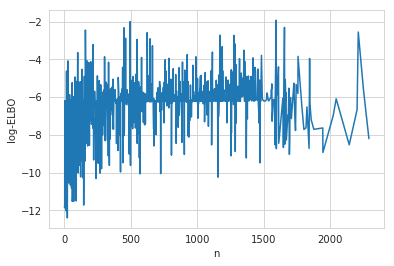

In [11]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [12]:
advi_trace = advi_fit.sample(500)

In [13]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm,0.259179,0.004831,0.000194,0.249980,0.269167
sigma,0.995364,0.018782,0.000757,0.951151,1.026065
sf_ecc_slope,0.509445,0.008101,0.000373,0.492128,0.523162
sf_ecc_intercept,0.448265,0.028002,0.001332,0.394971,0.500991


/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


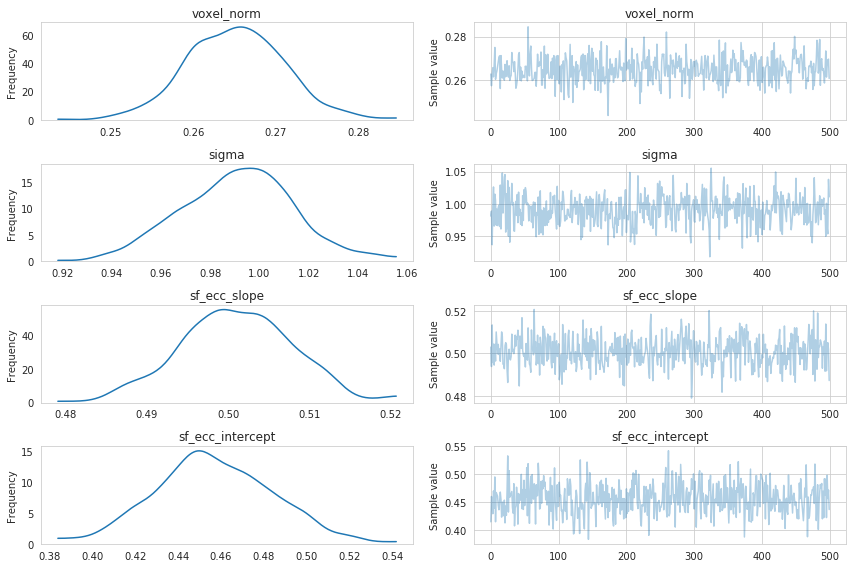

In [157]:
pm.traceplot(advi_trace);#, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

## MCMC

In [14]:
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)
df_sim.to_csv('test.csv')

In [38]:
inference_data = sfp.monte_carlo.main('test.csv', n_chains=8, n_samples=500, save_path='test.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sf_ecc_intercept, sf_ecc_slope, sigma, voxel_norm]
Sampling 8 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1232.74draws/s]
The acceptance probability does not match the target. It is 0.8834404058240792, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960706376917451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795208024442992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903270491689225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790188143032056, but should be close to 0.8. Try to increase the number of t

In [40]:
inference_data.posterior

<xarray.Dataset>
Dimensions:           (chain: 8, draw: 500)
Coordinates:
  * chain             (chain) int64 0 1 2 3 4 5 6 7
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
Data variables:
    voxel_norm        (chain, draw) float64 0.2638 0.269 ... 0.2672 0.2618
    sigma             (chain, draw) float64 0.9914 0.9874 ... 0.9791 1.008
    sf_ecc_slope      (chain, draw) float64 0.5218 0.4918 ... 0.4955 0.5279
    sf_ecc_intercept  (chain, draw) float64 0.3746 0.5357 ... 0.4515 0.4074
Attributes:
    created_at:                 2019-04-22T23:34:14.035253
    inference_library:          pymc3
    inference_library_version:  3.6
    first_level_results_path:   test.csv
    n_cores:                    8
    random_seed:                None
    df_filter_string:           None

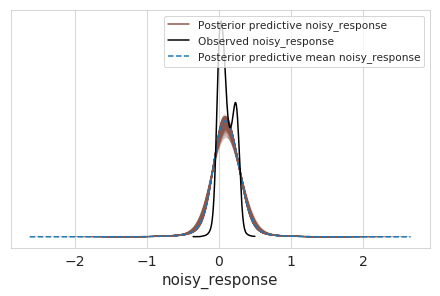

In [45]:
az.plot_ppc(inference_data);

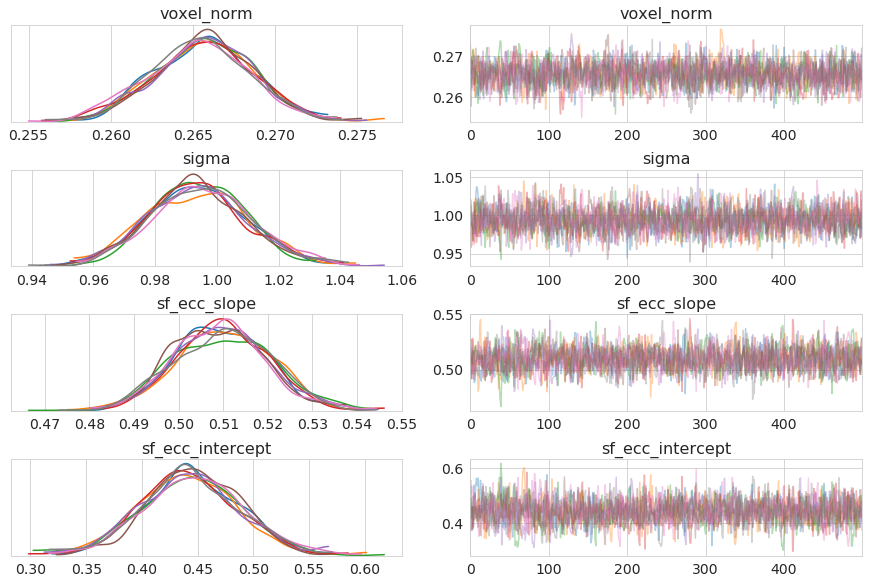

In [46]:
az.plot_trace(inference_data);

# Pyro
Need to rescale predictions and targets

In [36]:
dataset = sfp.model.FirstLevelDataset('tmp.csv', device,)# sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border'))
dataloader = torchdata.DataLoader(dataset, len(dataset))

In [43]:
import pyro
from pyro.infer import mcmc
model = sfp.model.LogGaussianDonut('full', 'full')

def call_model(features, precision):
    priors = {}
    for k, v in model.named_parameters():
        if not v.requires_grad:
            # we only want to deal with the parameters that require training
            continue
        if k == 'sigma':
            priors[k] = pyro.distributions.Normal(features.new_tensor(1), features.new_tensor(.25))
        elif k.startswith('sf'):
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
        else:
            #priors[k] = pyro.distributions.Gamma(1, 5)
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
    lifted_module = pyro.random_module('module', model, priors)
    lifted_model = lifted_module()
    predictions = lifted_model(features)
    rescaled_predictions = predictions / predictions.norm(2, -1, True)
    return pyro.sample('noisy_predictions', pyro.distributions.Normal(rescaled_predictions, 1./precision))

def call_conditioned_model(features, target, precision):
    rescaled_target = target / target.norm(2, -1, True)
    return pyro.condition(call_model, data={'noisy_predictions': rescaled_target})(features, precision)

In [41]:
features, targets = next(iter(dataloader))
precision = targets.select(-1, 1)
targets = targets.select(-1, 0)

In [55]:
pyro.clear_param_store()
nuts_kernel = mcmc.NUTS(call_conditioned_model, adapt_step_size=True)
hmc = mcmc.MCMC(nuts_kernel, num_samples=500, num_chains=1)

In [ ]:
# ISSUES WITH NUM_CHAINS > 1 probably due to issues with pytorch multiprocessing

In [56]:
hmc_posterior = hmc.run(features, targets, precision)

Sample: 100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s, step size=7.40e-02, acc. rate=0.955]


In [12]:
pyro_data_iso = az.from_pyro(hmc_posterior)

In [17]:
pyro_data_iso.posterior

<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 100)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    module$$$sigma             (chain, draw) float64 0.9697 0.9786 ... 0.9788
    module$$$sf_ecc_slope      (chain, draw) float64 0.74 0.733 ... 0.7448
    module$$$sf_ecc_intercept  (chain, draw) float64 0.1867 0.2494 ... 0.1943
Attributes:
    created_at:                 2019-04-02T21:30:08.832168
    inference_library:          pyro
    inference_library_version:  0.3.1

In [18]:
pyro_data_full.posterior

<xarray.Dataset>
Dimensions:                           (chain: 1, draw: 100)
Coordinates:
  * chain                             (chain) int64 0
  * draw                              (draw) int64 0 1 2 3 4 ... 95 96 97 98 99
Data variables:
    module$$$sigma                    (chain, draw) float64 0.9748 ... 0.9711
    module$$$abs_amplitude_cardinals  (chain, draw) float64 0.003297 ... -0.002975
    module$$$abs_amplitude_obliques   (chain, draw) float64 -0.004145 ... 0.001009
    module$$$rel_amplitude_cardinals  (chain, draw) float64 -0.002018 ... -0.00707
    module$$$rel_amplitude_obliques   (chain, draw) float64 0.003386 ... -0.0009014
    module$$$abs_mode_cardinals       (chain, draw) float64 -0.001487 ... -0.005134
    module$$$abs_mode_obliques        (chain, draw) float64 -0.002583 ... -0.002509
    module$$$rel_mode_cardinals       (chain, draw) float64 -0.00794 ... -0.001675
    module$$$rel_mode_obliques        (chain, draw) float64 -0.0003585 ... 0.000501
    module$$$s

In [57]:
params = ['module$$$'+i[0] for i in model.named_parameters()]
marginals = hmc_posterior.marginal(params)
marginals.support().keys()

odict_keys(['module$$$sigma', 'module$$$abs_amplitude_cardinals', 'module$$$abs_amplitude_obliques', 'module$$$rel_amplitude_cardinals', 'module$$$rel_amplitude_obliques', 'module$$$abs_mode_cardinals', 'module$$$abs_mode_obliques', 'module$$$rel_mode_cardinals', 'module$$$rel_mode_obliques', 'module$$$sf_ecc_slope', 'module$$$sf_ecc_intercept'])

In [58]:
samples = {}
for k, v in marginals.support().items():
    samples[k.replace('module$$$', '')] = v
samples = pd.DataFrame(samples)
samples['sample_num'] = range(len(samples))
samples = pd.melt(samples, 'sample_num', var_name='model_parameter')

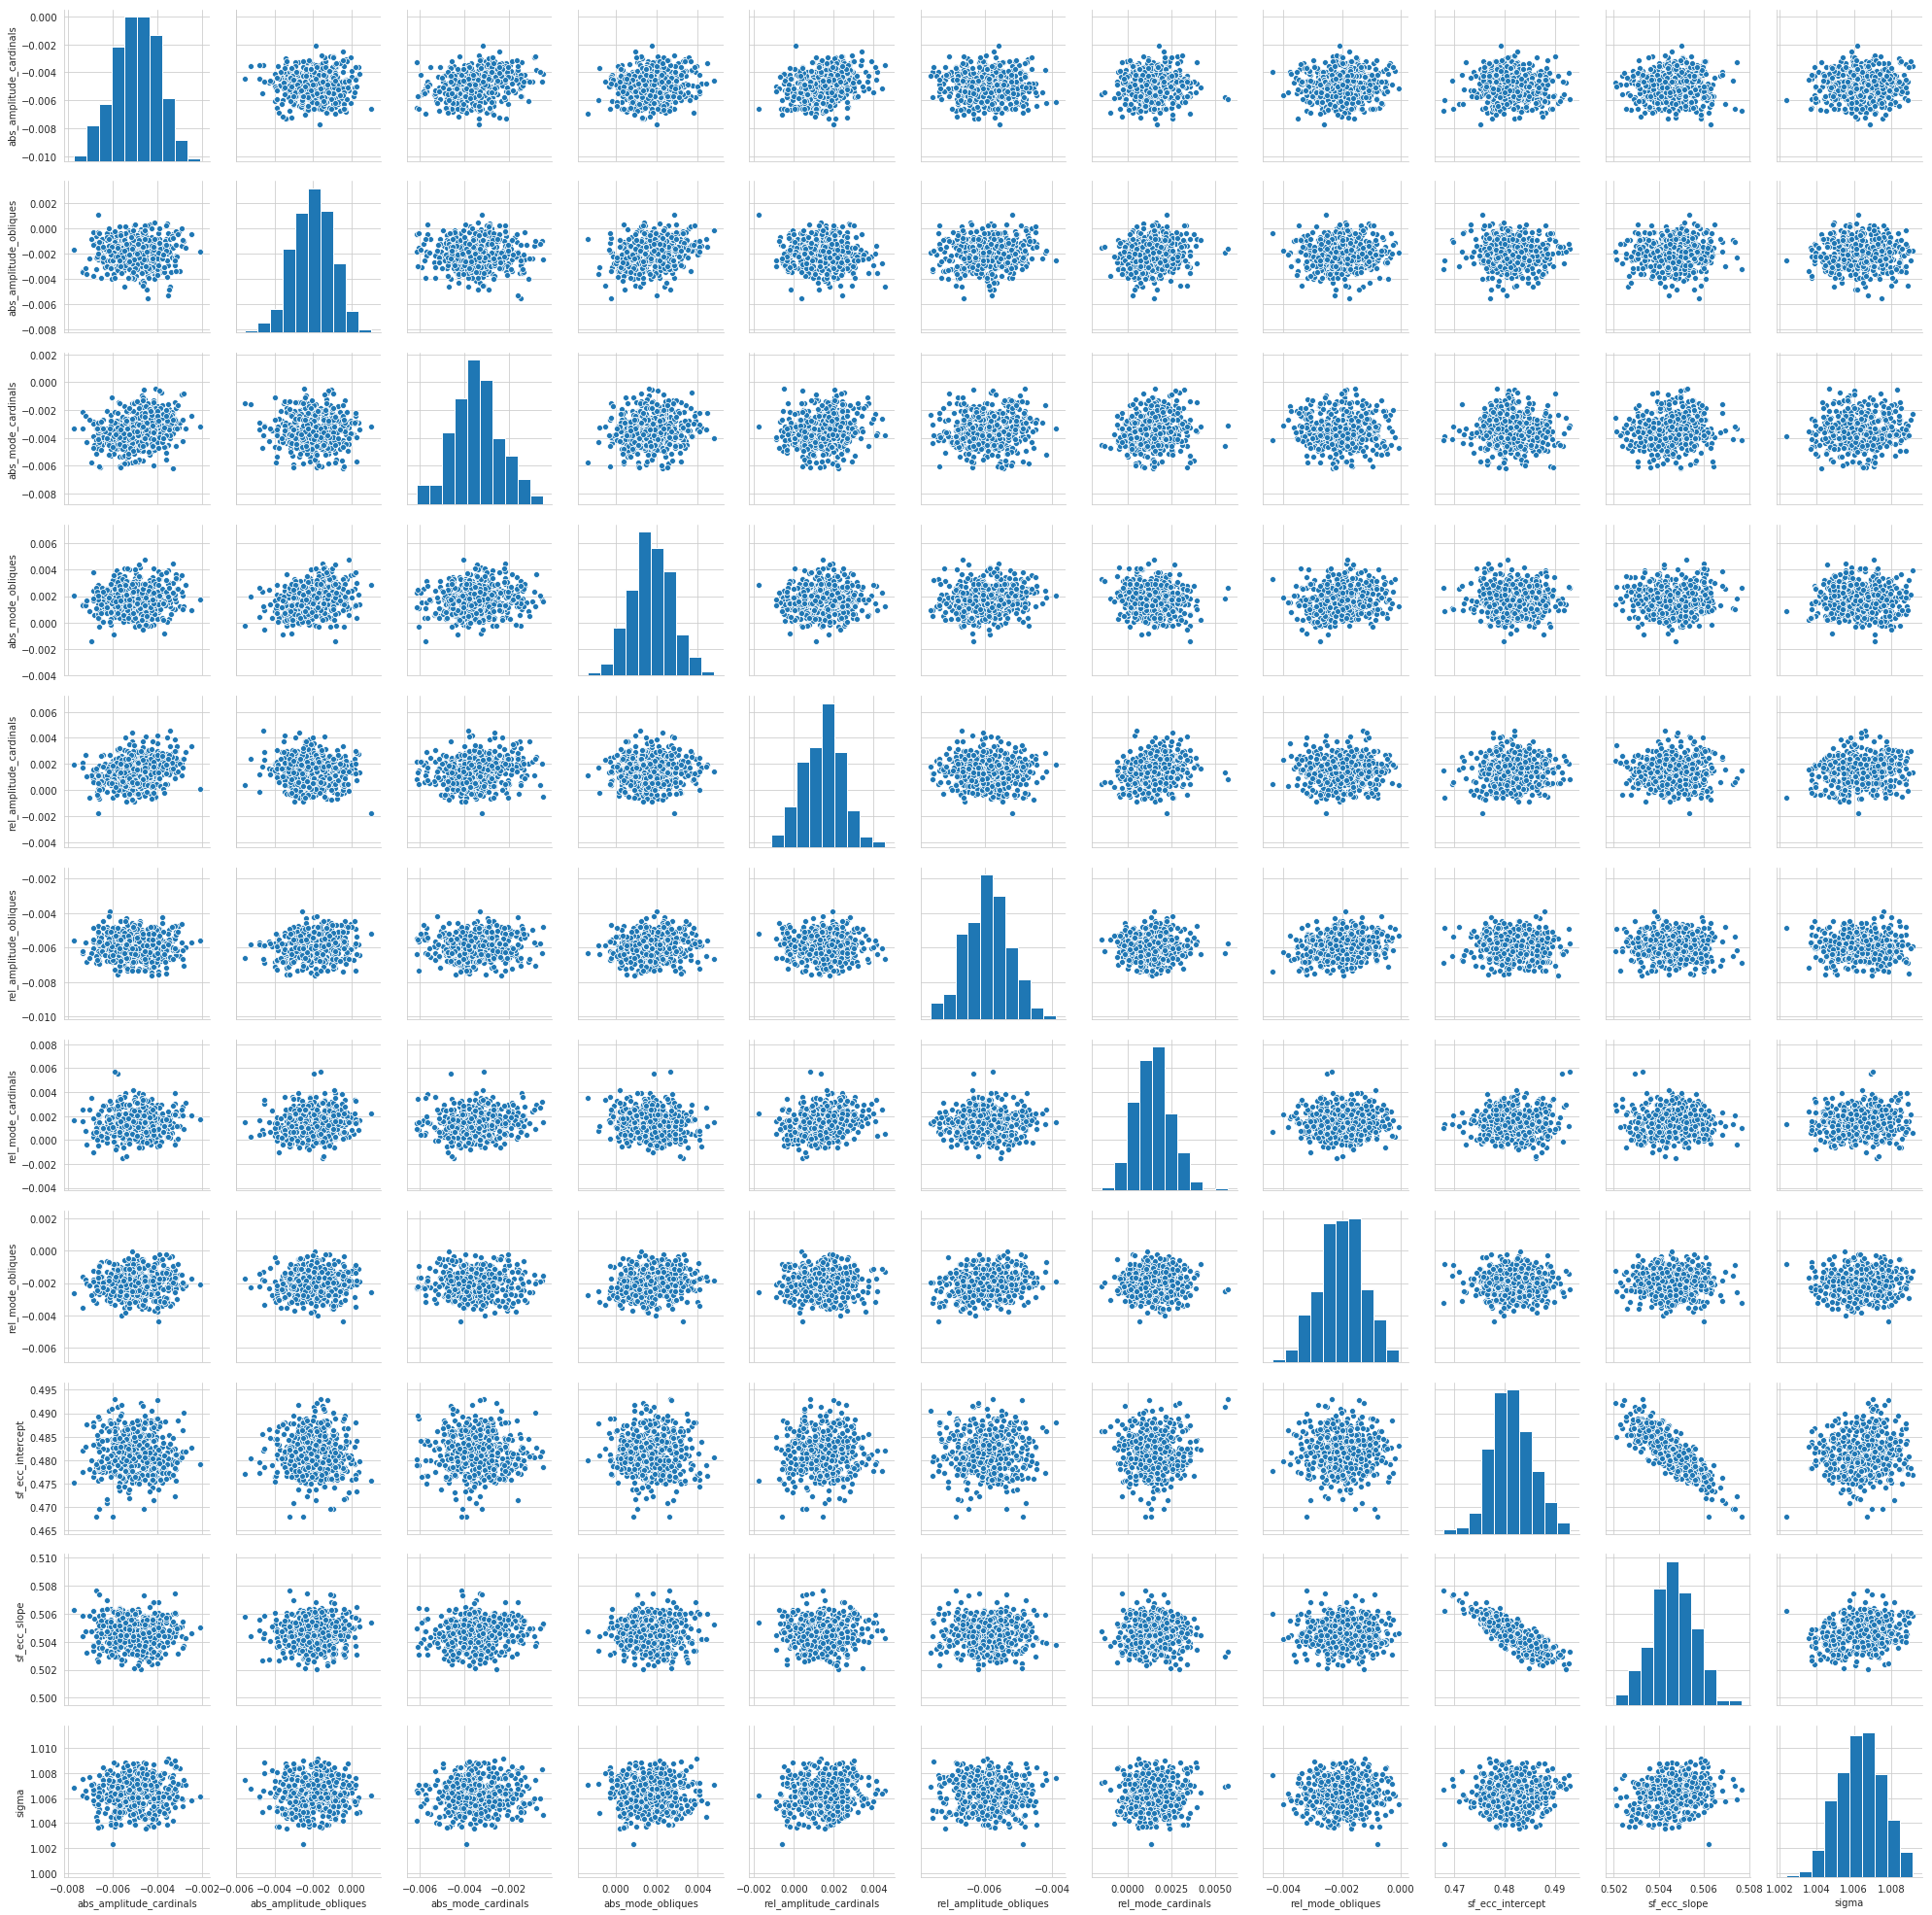

In [59]:
sns.pairplot(samples.pivot('sample_num', 'model_parameter', 'value'))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


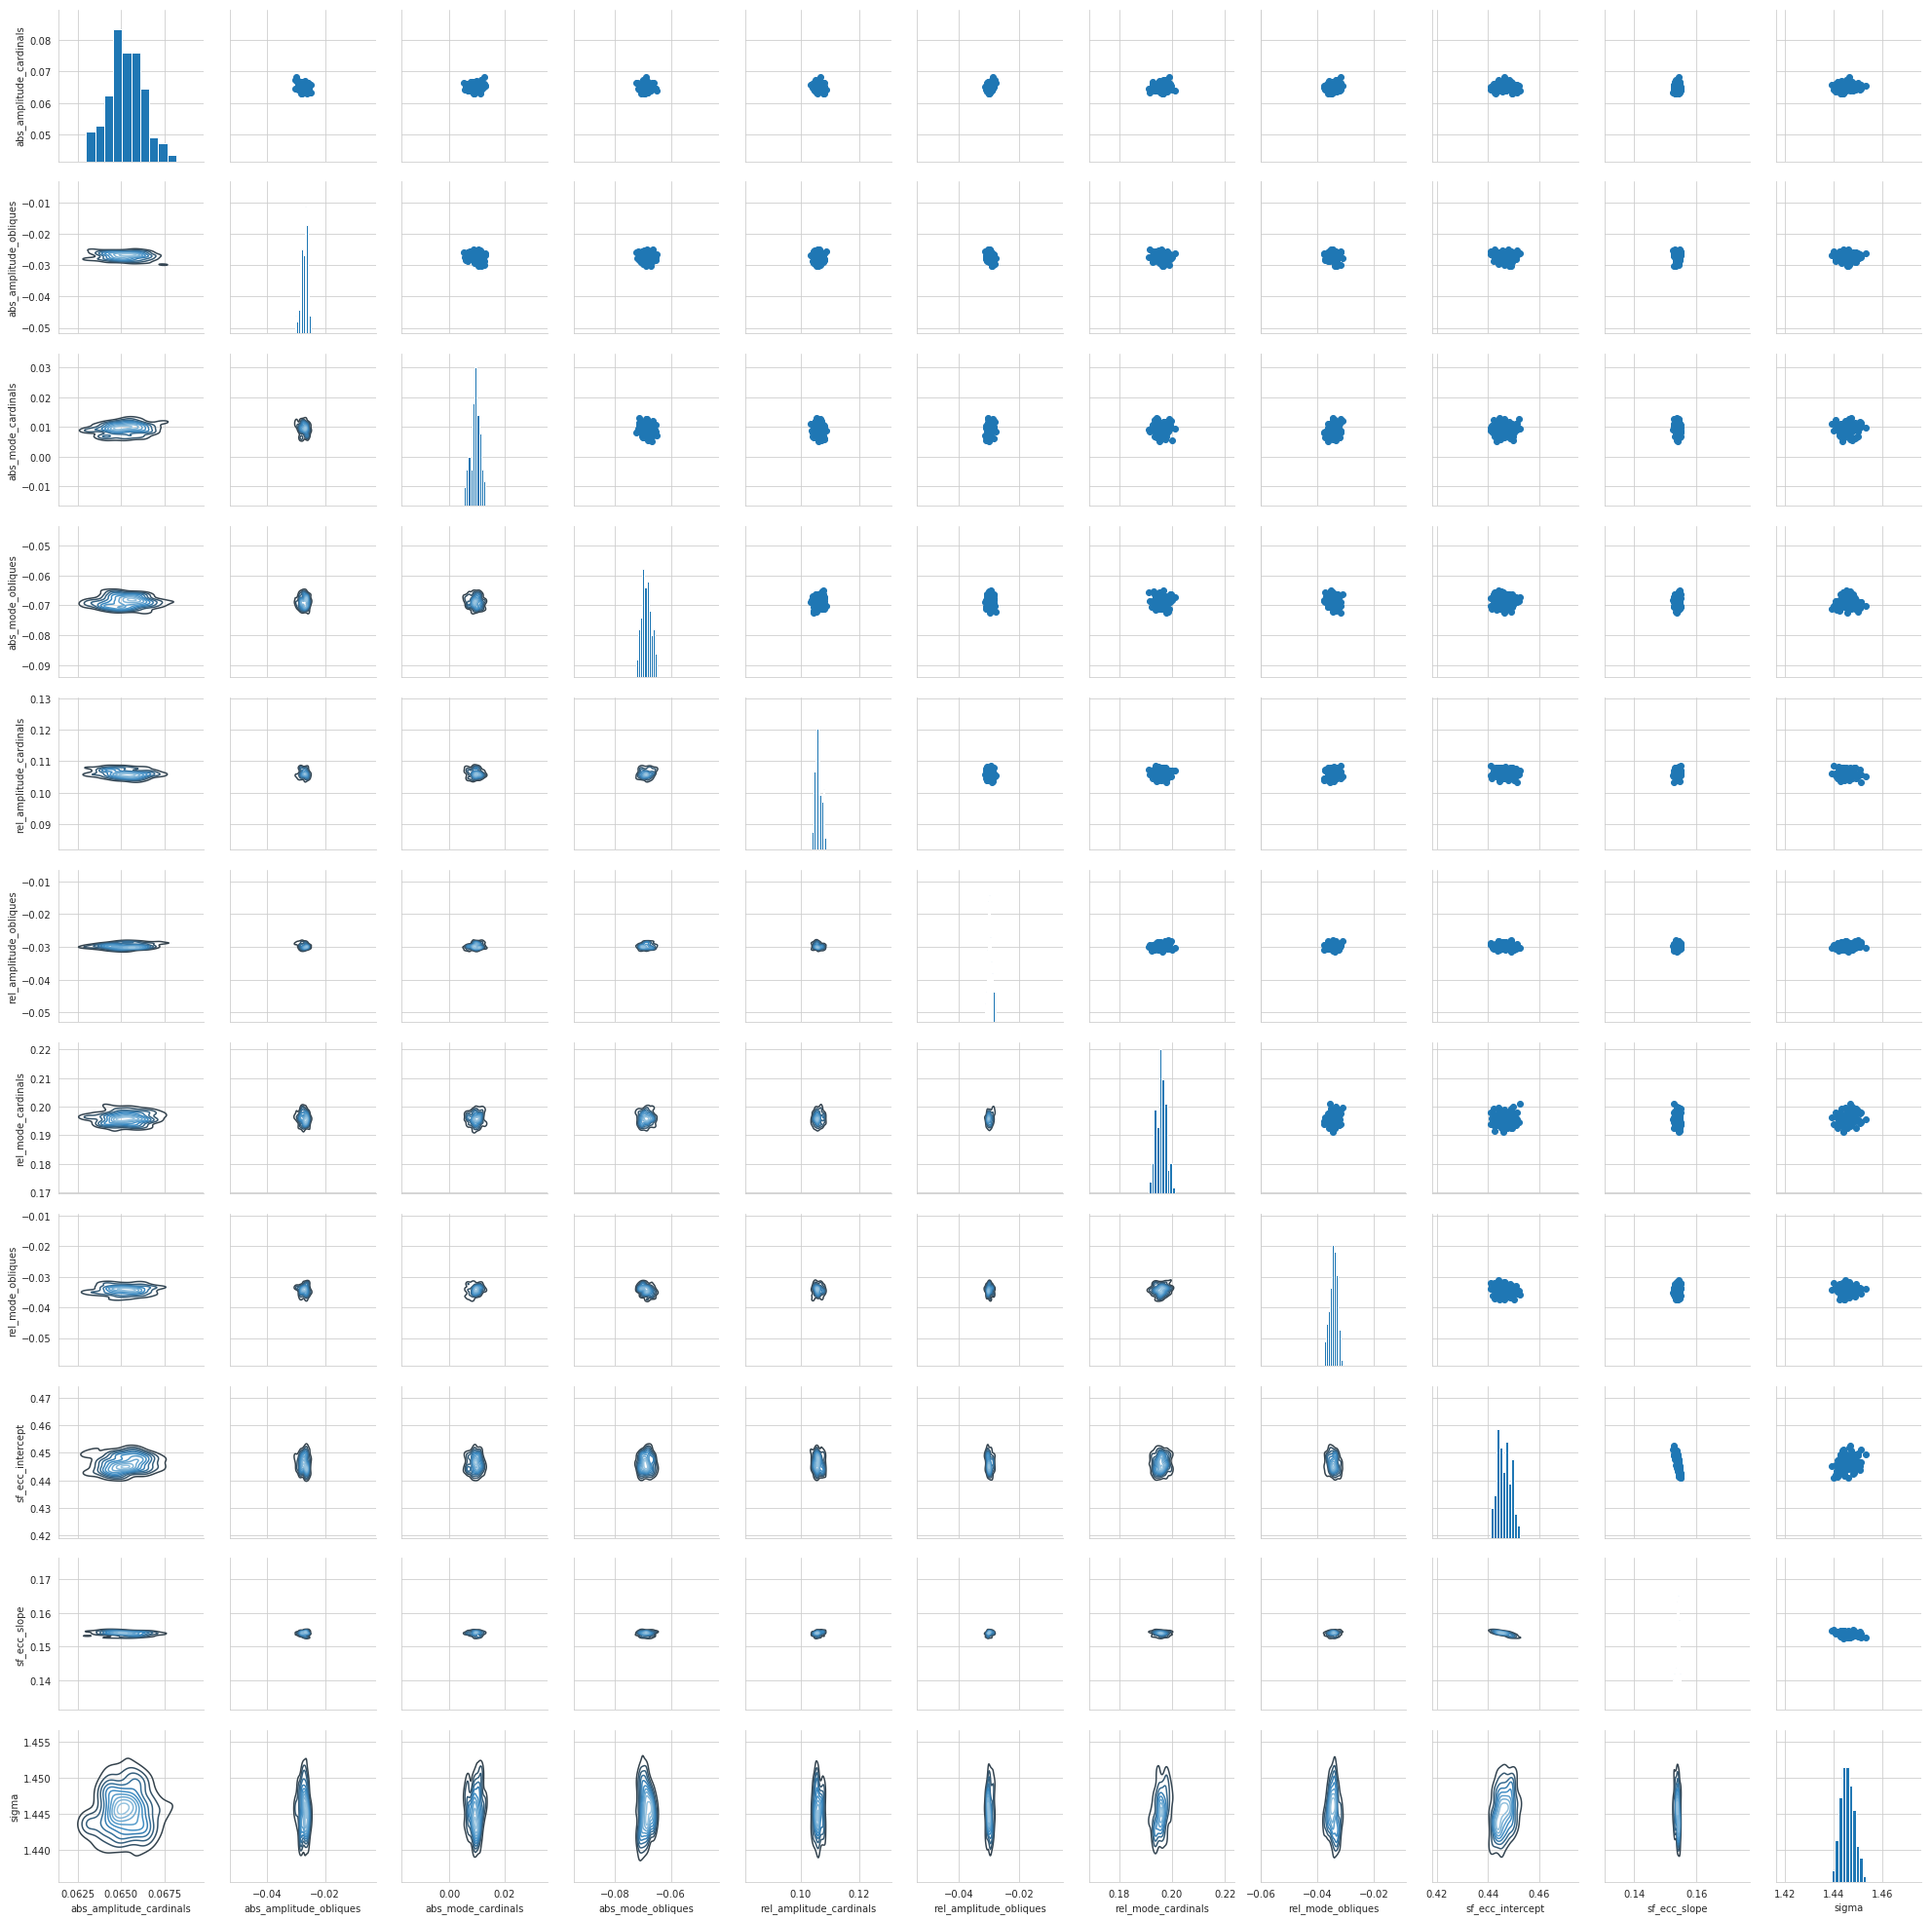

In [213]:
g = sns.PairGrid(samples.pivot('sample_num', 'model_parameter', 'value'))
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

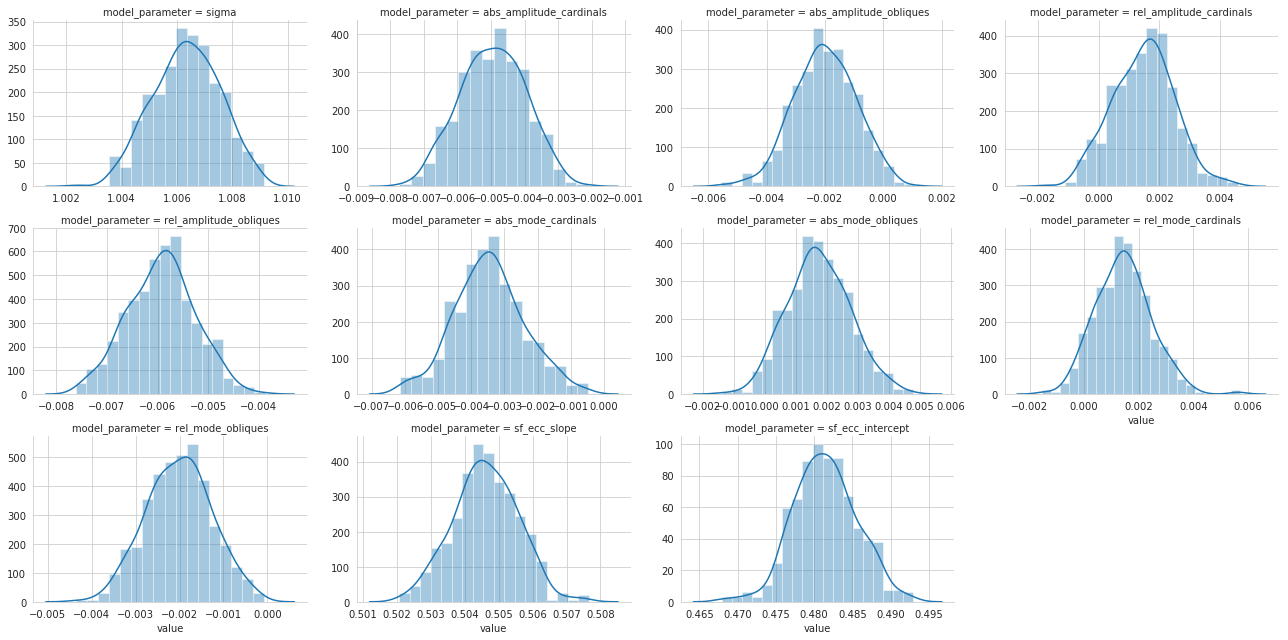

In [60]:
g = sns.FacetGrid(samples, col='model_parameter', col_wrap=4, sharex=False, sharey=False, aspect=1.5)
g.map(sns.distplot, 'value')

In [142]:
# cusum plot:
means = {}
cusum = {}
for p in params:
    means[p] = marginals.support()[p].mean()
    cusum[p] = []
    for t in range(len(marginals.support()[p])):
        cusum[p].append((marginals.support()[p][:t] - means[p]).sum())

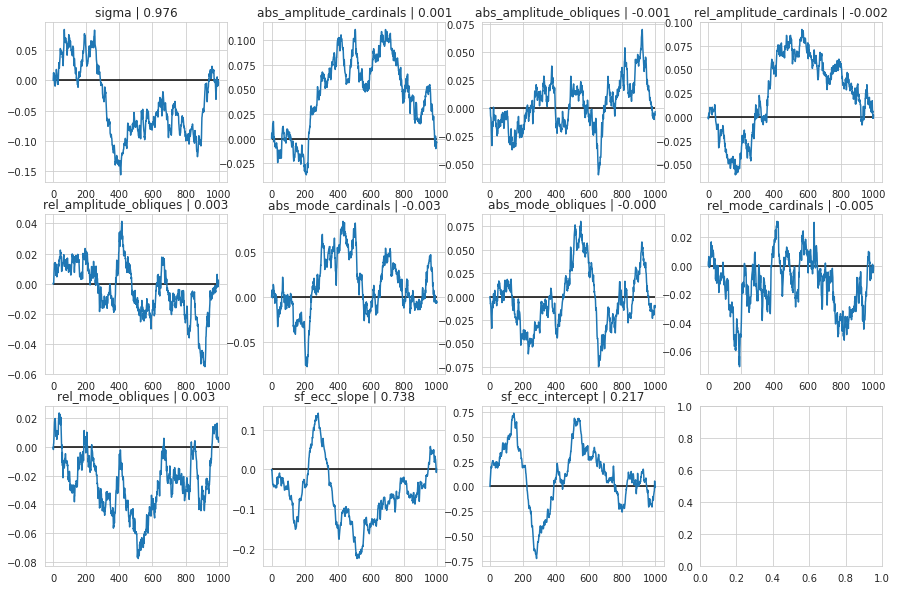

In [143]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(cusum[p])
    ax.hlines(0, 0, len(cusum[p]))
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))

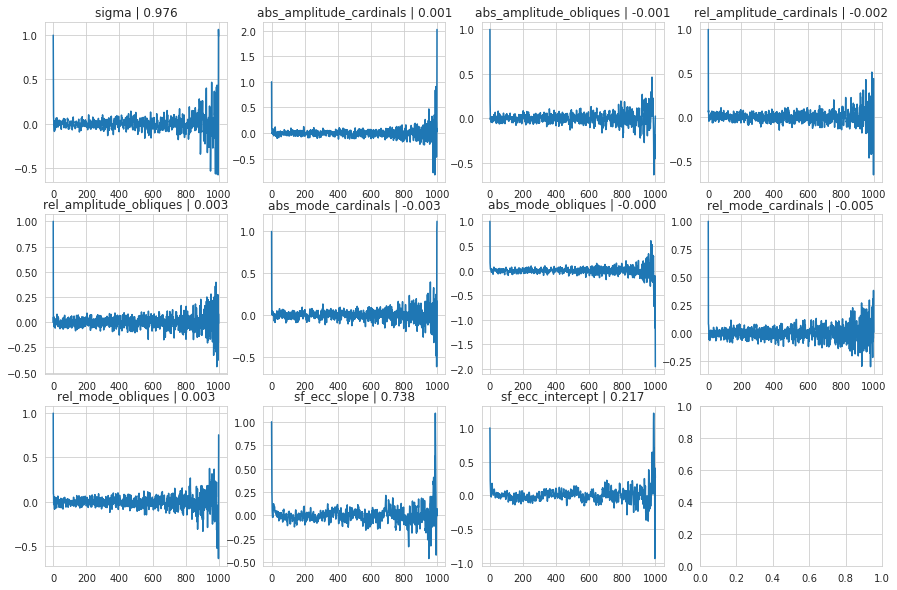

In [151]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(pyro.ops.stats.autocorrelation(marginals.support()[p]).numpy())
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))

# PyStan

In [3]:
import pystan

In [56]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6917c9f61b43d32be9e02f75e25639e0 NOW.


CompileError: command 'gcc' failed with exit status 1

In [89]:
data = az.from_pystan(posterior=fit,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'school': np.arange(schools_dat['J'])},
                      dims={'theta': ['school'],
                             'y': ['school'],
                             'log_lik': ['school'],
                             'y_hat': ['school'],
                             'theta_tilde': ['school']
                            }
                     )


In [4]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100)

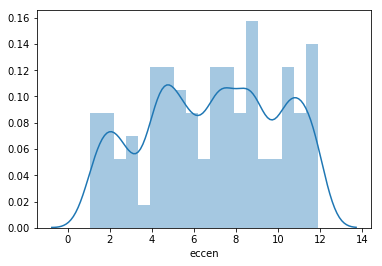

In [5]:
sns.distplot(df_sim.eccen)

In [ ]:
def pymc_log_gauss_donut(sf_mag, sf_angle, vox_ecc, vox_angle, targets, precision, n_voxels,
                         orientation_type='iso', eccentricity_type='full', vary_amplitude=False):
    random_param, param_val = {}, {}
    for ori, param, angle in itertools.product(['abs', 'rel'], ['mode', 'amplitude'],
                                               ['cardinals', 'obliques']):
        random_param['%s_%s_%s' % (ori, param, angle)] = True
        param_val['%s_%s_%s' % (ori, param, angle)] = 0
    for var in ['slope', 'intercept']:
        random_param['sf_ecc_%s' % var] = True
        param_val['sf_ecc_%s' % var] = .5
    param_val, random_param = sfp.model._check_log_gaussian_params(param_val, random_param, orientation_type, 
                                                                   eccentricity_type, vary_amplitude)
    params = {}
    model = pm.Model()
    with model:
        #normed_targets = targets / targets.norm(2, 1, keepdims=True)
        # voxel_norm = pm.Normal('voxel_norm', mu=1, sd=.25, shape=(n_voxels, 1), )
        params['sigma'] = pm.Normal('sigma', mu=1, sd=.25)
        for k, v in param_val.items():
            if random_param[k]:
                params[k] = pm.Normal(k, mu=v, sd=.25)
            else:
                params[k] = pm.Deterministic(k, tt.as_tensor(v))
        rel_sf_angle = sf_angle - vox_angle
        eccentricity_effect = params['sf_ecc_slope'] * vox_ecc + params['sf_ecc_intercept']
        orientation_effect = (1 + params['abs_mode_cardinals'] * tt.cos(2 * sf_angle) +
                              params['abs_mode_obliques'] * tt.cos(4 * sf_angle) +
                              params['rel_mode_cardinals'] * tt.cos(2 * rel_sf_angle) +
                              params['rel_mode_obliques'] * tt.cos(4 * rel_sf_angle))
        preferred_period = pm.math.clip(eccentricity_effect * orientation_effect, 1e-6, 1e6)

        max_amplitude = pm.math.clip(1 + params['abs_amplitude_cardinals'] * tt.cos(2*sf_angle) +
                                     params['abs_amplitude_obliques'] * tt.cos(4*sf_angle) +
                                     params['rel_amplitude_cardinals'] * tt.cos(2*rel_sf_angle) +
                                     params['rel_amplitude_obliques'] * tt.cos(4*rel_sf_angle), 1e-6, 1e6)
        pdf = tt.exp(-((tt.log2(sf_mag) + tt.log2(preferred_period))**2) / (2*params['sigma']**2))
        predicted_response = max_amplitude * pdf
        noisy_response = pm.Normal('noisy_response', mu=predicted_response, sd=1./precision, observed=targets,)
    return model

In [10]:
model = sfp.model.LogGaussianDonut()

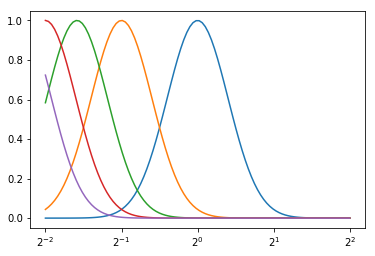

In [41]:
x = np.logspace(-2, 2, 100, base=2)
v = np.array([1,2,3,4,5])
x = np.repeat(np.expand_dims(x, 0), len(v), 0)
v = np.repeat(np.expand_dims(v, 1), x.shape[1], 1)
plt.semilogx(x.T, model.evaluate(x, 0, v, 0).detach().numpy().T, basex=2);

In [55]:
log_gauss_code = """
data {
    int<lower=0> V; // number of voxels
    int<lower=0> N; // number of stimulus classes
    vector[N] vox_eccentricity[V]; // voxel eccentricity
    vector[N] vox_angle[V]; // voxel_angle (in radians)
    vector[N] sf_mag[V]; // stimulus spatial frequency
    vector[N] sf_ori[V]; // stimulus orientation
    vector[N] y[V]; // estimated responses
    vector[N] sigma_V[V]; // s.e. of response estimates
}
parameters {
    real<lower=0> sigma;
    real sf_ecc_slope;
    real sf_ecc_intercept;
}
transformed parameters {
    vector[N] eccentricity_effect[V];
    vector[N] pdf[V];
    for (n in 1:N) {
        eccentricity_effect[n] = sf_ecc_slope * vox_eccentricity[n] + sf_ecc_intercept;
        pdf[n] = exp(-square(log2(sf_mag[n])+log2(eccentricity_effect[n])) / (2*square(sigma)));
    }
}
model {
    for (n in 1:N) {
        y[n] ~ normal(pdf[n], sigma_V[n]);
    }
}
//generated quantities {
//    vector[N] log_lik[V];
//    vector[N] y_hat[V];
//    for (n in 1:N) {
//        log_lik[n] = normal_lpdf(y[n] | pdf[n], sigma[n]);
//        y_hat[n] = normal_rng(pdf[n], sigma[n]);
//    }
//}
"""

sm = pystan.StanModel(model_code=log_gauss_code)
#fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7af4bbb11db287c3cc697a0187712e9a NOW.


CompileError: command 'gcc' failed with exit status 1

In [ ]:
fit = sm.sampling(data=voxel_dat, iter=500, chains=4)